In [31]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from os import PathLike
from IPython.display import display
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from typing import cast, Tuple
from random import randint

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

set_custom_plot_style()
cm = 1 / 2.54

redo_all = True
export = True

eval = MammaliaEval(
    path_config='../../data/path_config.yml',
    metrics=['balanced_accuracy_score'],
    force_metrics=False
    )

# paths = load_path_yaml('../../data/path_config.yml')

# best_model = LoadRun(
#     log_path=paths['complete_models'] / 'efficientnet_b0_v4_pretrained_cross_val',
#     paths=paths
#     )


Loading pre-calculated metrics from file...


In [30]:
eval.best_model.full_predicted_set

,idx,seq_id,class_id,class_label,SerialNumber,n_files,file_path,bbox,conf,fold,set,pred_id,probs,correct,pred_label,probs_max
0,0,3000000,0,apodemus_sp,H550HF07158839,24,sessions/session_03/28/IMG_0016.JPG,"[0.0888, 0.5299, 0.3642, 0.1979]",0.979,2,test,0,"[1.0, 0.0, 0.0, 0.0]",True,apodemus_sp,1.0000
1,1,3000000,0,apodemus_sp,H550HF07158839,24,sessions/session_03/28/IMG_0018.JPG,"[0.1845, 0.5345, 0.2705, 0.1946]",0.973,2,test,0,"[1.0, 0.0, 0.0, 0.0]",True,apodemus_sp,1.0000
2,2,3000000,0,apodemus_sp,H550HF07158839,24,sessions/session_03/28/IMG_0019.JPG,"[0.1054, 0.5716, 0.3535, 0.1523]",0.970,2,test,0,"[1.0, 0.0, 0.0, 0.0]",True,apodemus_sp,1.0000
3,3,3000000,0,apodemus_sp,H550HF07158839,24,sessions/session_03/28/IMG_0017.JPG,"[0.1533, 0.5833, 0.2822, 0.2252]",0.968,2,test,0,"[1.0, 0.0, 0.0, 0.0]",True,apodemus_sp,1.0000
4,4,3000000,0,apodemus_sp,H550HF07158839,24,sessions/session_03/28/IMG_0007.JPG,"[0.101, 0.5468, 0.1655, 0.1757]",0.961,2,test,0,"[1.0, 0.0, 0.0, 0.0]",True,apodemus_sp,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430427,430427,4018687,2,cricetidae,H550HF08161368,6,sessions/session_04/W7-WK06/IMG_4267.JPG,"[0.187, 0.4342, 0.1254, 0.1569]",0.776,3,test,3,"[0.0054, 0.0, 0.0, 0.9946]",False,soricidae,0.9946
430428,430428,4018687,2,cricetidae,H550HF08161368,6,sessions/session_04/W7-WK06/IMG_4266.JPG,"[0.186, 0.4335, 0.1113, 0.1627]",0.716,3,test,3,"[0.0015, 0.0, 0.0, 0.9985]",False,soricidae,0.9985
430429,430429,4018688,3,soricidae,H550HF08161368,3,sessions/session_04/W7-WK06/IMG_4270.JPG,"[0.6201, 0.6126, 0.2275, 0.1549]",0.946,0,test,3,"[0.0, 0.0, 0.0, 1.0]",True,soricidae,1.0000
430430,430430,4018688,3,soricidae,H550HF08161368,3,sessions/session_04/W7-WK06/IMG_4271.JPG,"[0.2734, 0.5709, 0.1904, 0.0618]",0.857,0,test,3,"[0.0, 0.0, 0.0, 1.0]",True,soricidae,1.0000


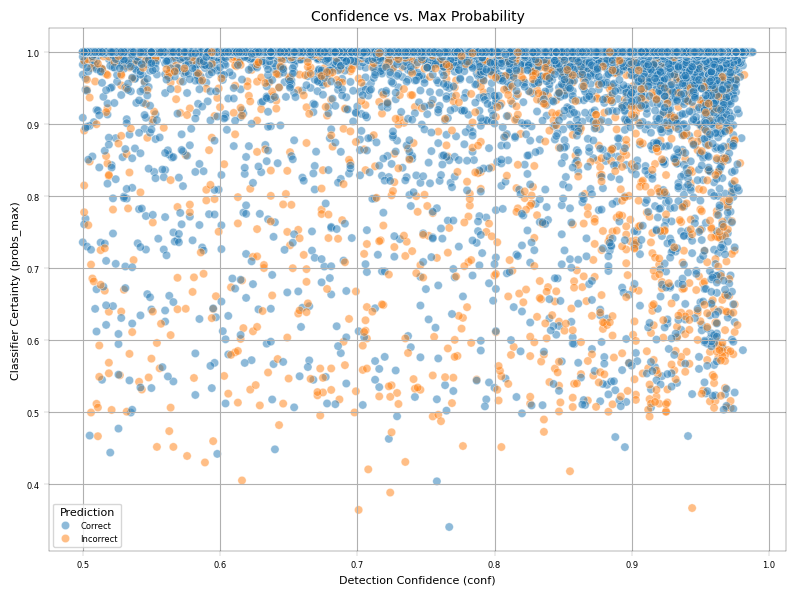

In [32]:

df = eval.best_model.full_predicted_set
df['correct_str'] = df['correct'].map({True: 'Correct', False: 'Incorrect'})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='conf', y='probs_max', hue='correct_str', alpha=0.5)
plt.title('Confidence vs. Max Probability')
plt.xlabel('Detection Confidence (conf)')
plt.ylabel('Classifier Certainty (probs_max)')
plt.grid(True)
plt.legend(title='Prediction')
plt.tight_layout()
plt.show()

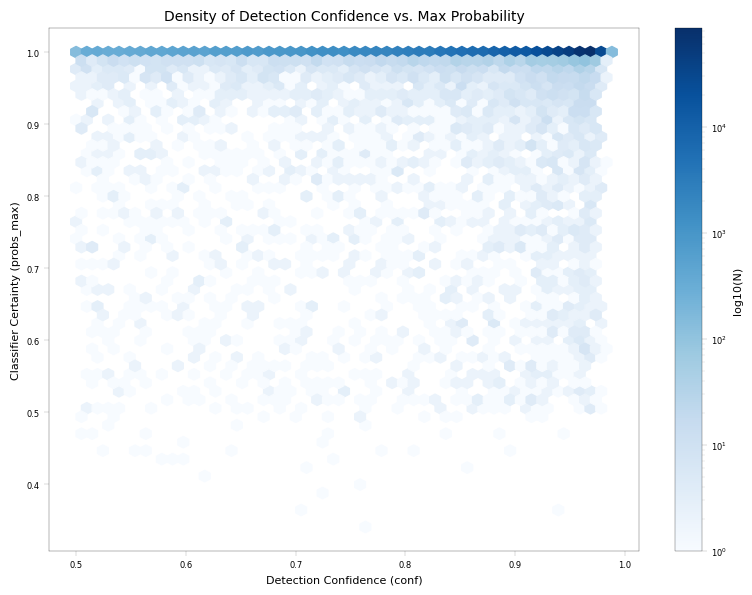

In [37]:
plt.figure(figsize=(8, 6))
plt.hexbin(
    df['conf'], df['probs_max'], 
    gridsize=50, cmap='Blues', bins='log'
)
plt.title('Density of Detection Confidence vs. Max Probability')
plt.xlabel('Detection Confidence (conf)')
plt.ylabel('Classifier Certainty (probs_max)')
plt.colorbar(label='log10(N)')
plt.tight_layout()
plt.show()

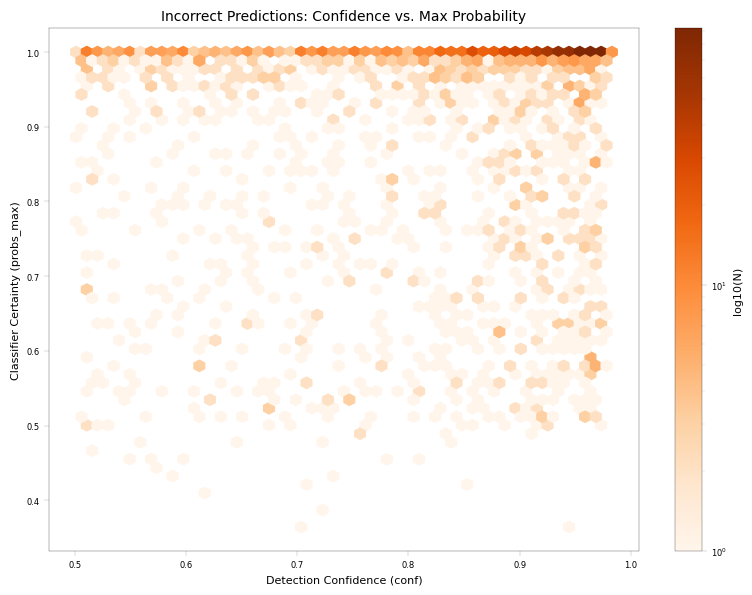

In [38]:
plt.figure(figsize=(8, 6))
plt.hexbin(
    df[df['correct'] == False]['conf'], 
    df[df['correct'] == False]['probs_max'], 
    gridsize=50, cmap='Oranges', bins='log'
)
plt.title('Incorrect Predictions: Confidence vs. Max Probability')
plt.xlabel('Detection Confidence (conf)')
plt.ylabel('Classifier Certainty (probs_max)')
plt.colorbar(label='log10(N)')
plt.tight_layout()
plt.show()

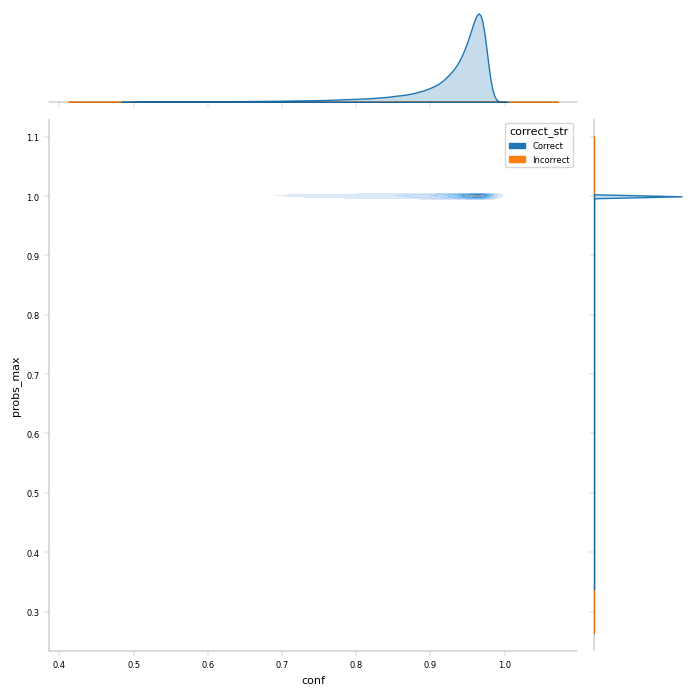

In [39]:
sns.jointplot(
    data=df, x='conf', y='probs_max',
    hue='correct_str', kind='kde', fill=True, alpha=0.4,
    height=7
)
plt.tight_layout()

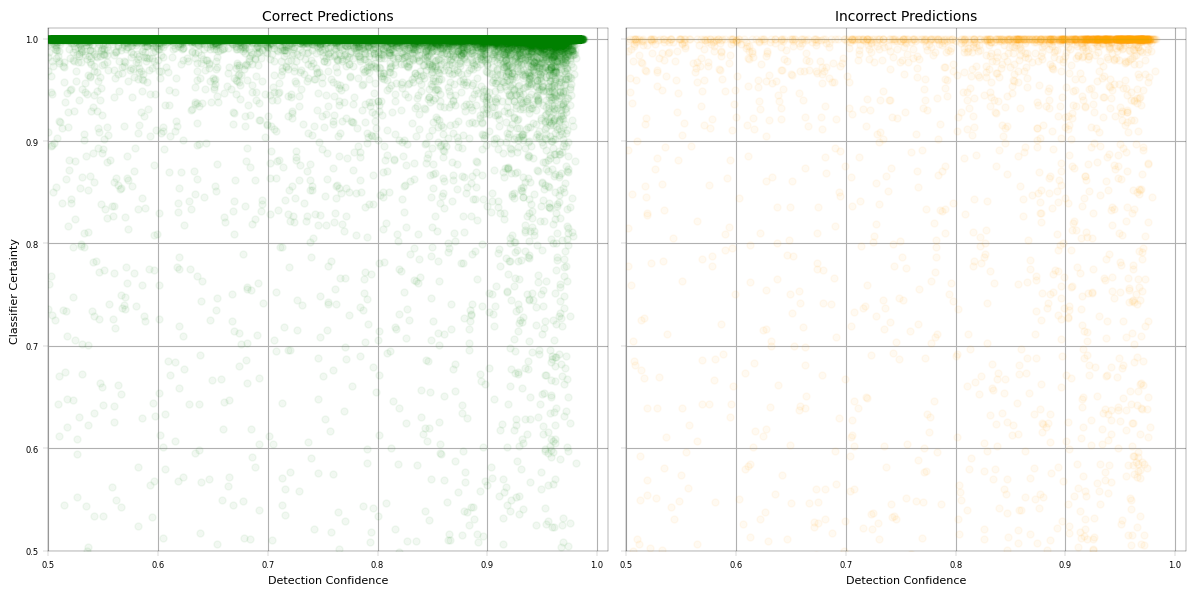

In [50]:
import matplotlib.pyplot as plt

# Subset data
df_correct = df[df['correct'] == True]
df_incorrect = df[df['correct'] == False]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot: Correct
axes[0].plot(
    df_correct['conf'], df_correct['probs_max'],
    linestyle='', marker='o', markersize=5, alpha=0.05, color='green'
)
axes[0].set_title('Correct Predictions')
axes[0].set_xlabel('Detection Confidence')
axes[0].set_ylabel('Classifier Certainty')

# Plot: Incorrect
axes[1].plot(
    df_incorrect['conf'], df_incorrect['probs_max'],
    linestyle='', marker='o', markersize=5, alpha=0.05, color='orange'
)
axes[1].set_title('Incorrect Predictions')
axes[1].set_xlabel('Detection Confidence')

# Styling
for ax in axes:
    ax.grid(True)
    ax.set_xlim(0.5, 1.01)
    ax.set_ylim(0.5, 1.01)

plt.tight_layout()
plt.show()

## Checking List of the false prediction with the highest accuracy

In [ ]:
predictions = eval.best_model.get_predictions(filter_by='incorrect', sort='probs_max', fold=0)
idx_to_check = predictions['idx'].tolist()
current_sample = 0


idx: 232461
true_class: 2 - cricetidae
pred_class: 0 - apodemus_sp
classification confidence: 1.0


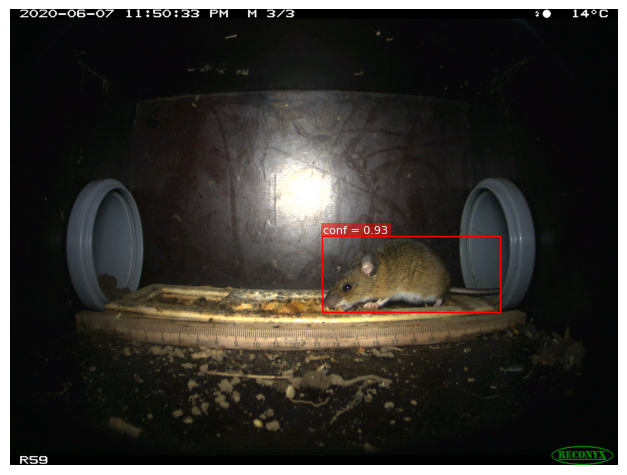

In [87]:
idx = idx_to_check[current_sample]
prediction = predictions.loc[predictions['idx'] == idx].squeeze().to_dict()

true_class = prediction["class_id"]
pred_class = prediction["pred_id"]

print(f'idx: {idx}')
print(f'true_class: {true_class} - {eval.best_model.decoder[true_class]}')
print(f'pred_class: {pred_class} - {eval.best_model.decoder[pred_class]}')
print(f'classification confidence: {prediction["probs_max"]}')
figure = eval.best_model.show_sample(idx)

current_sample += 1


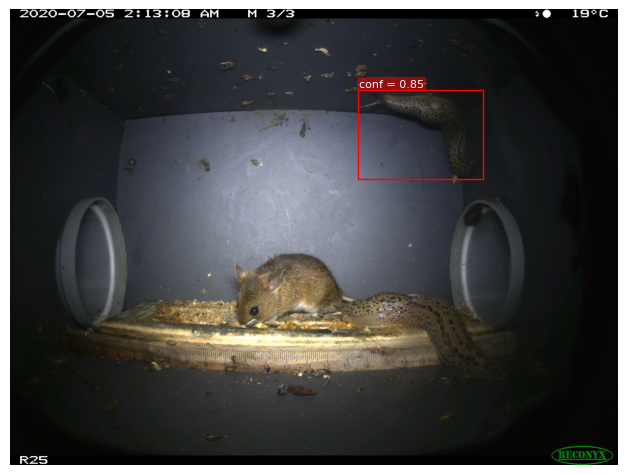

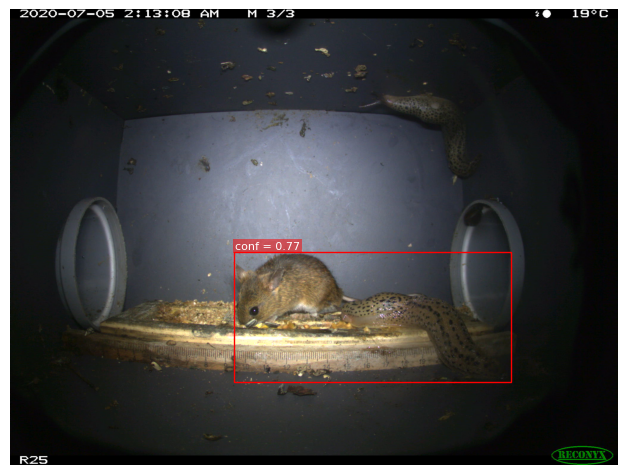

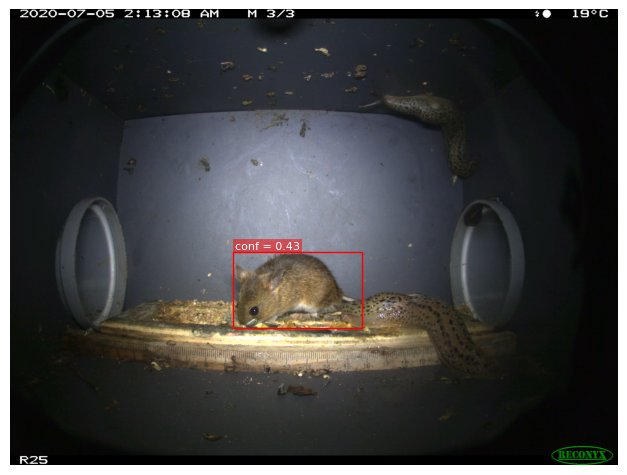

In [78]:
idx = 369260

figures = eval.best_model.show_all_bboxes_for_image(
    idx=idx
    )

